# Spotify Data Analysis

In [40]:
# import libraries
import pickle
import string
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn.apionly as sns #sets up styles and gives us more plotting options
%matplotlib inline

#### Local Data file directory (Update this with your own directory)

In [2]:
# Local data folder to save data to and pull data from
### NOTE to partners: comment out mine; use your own local folder path
data_folder = "/Users/dannynightingale/Documents/Harvard 2017-2018/Harvard 2017-2018 Fall/CS 109a/Spotify Final Project/data/"

### your local folder here:
# data_folder = Hartin's directory



In [3]:
# unpickle 
spotify_data = pd.read_pickle(data_folder + "spotify_data")

In [4]:
spotify_data.head(3)

,followers,pl_description,pl_href,pl_id,pl_length,pl_name,track_added,track_album_id,track_album_name,track_artists_id1,...,track_energy,track_instrumentalness,track_key,track_liveness,track_loudness,track_mode,track_speechiness,track_tempo,track_time_signature,track_valence
1559039,4594125,"""mint is original, Spotify's freshest electron...",https://api.spotify.com/v1/users/spotify/playl...,37i9dQZF1DX4dyzvuaRJ0n,60,mint,2017-11-17T02:38:57Z,3MayKx4qydJTtqesdPJz3t,Off The Deep End Volume One,5ttgIeUVka6FLyi00Uu5h8,...,0.634,0.000004,5.0,0.1120,-5.178,0.0,0.0652,180.153,4.0,0.398
893872,4594125,"""mint is original, Spotify's freshest electron...",https://api.spotify.com/v1/users/spotify/playl...,37i9dQZF1DX4dyzvuaRJ0n,60,mint,2017-11-17T02:38:57Z,0t9xxSsMcwpf9AVcH1o9q9,Without You (Remixes),1vCWHaC5f2uS3yhpwWbIA6,...,0.850,0.004350,2.0,0.0741,-4.851,1.0,0.0809,131.094,4.0,0.470
334899,4594125,"""mint is original, Spotify's freshest electron...",https://api.spotify.com/v1/users/spotify/playl...,37i9dQZF1DX4dyzvuaRJ0n,60,mint,2017-11-19T15:45:15Z,23nYYartVhPNNmEdCeyS2x,Message In A Bottle,7AbYSzOocUvzy7DSJ9gm68,...,0.939,0.000311,1.0,0.0818,-3.936,0.0,0.1030,120.076,4.0,0.370


In [5]:
spotify_data.shape

(2616111, 38)

In [6]:
# variable descriptions
## spotify field descriptions from: https://developer.spotify.com/web-api/object-model/#track-object-full
var_descr = [ \
"Number of Playlist Followers", \
"Playlist Description", \
"Playlist href (for querying spotify)", \
"Playlist Spotify ID", \
"Number of songs in playlist", \
"Playlist Name", \
"Time track added to playlist", \
"Track Album Spotify ID", \
"Track Album Name", \
"Track Artist 1 Spotify ID", \
"Track Artist 2 Spotify ID", \
"Track Artist 3 Spotify ID", \
"Track Artist 4 Spotify ID", \
"Track Artist 5 Spotify ID", \
"Track Artist 1 Name", \
"Track Artist 2 Name", \
"Track Artist 3 Name", \
"Track Artist 4 Name", \
"Track Artist 5 Name", \
"Track Explicit (True or False)", \
"Track href (for querying spotify)", \
"Track Spotify ID", \
"Track ISRC number (for linking to other datasets)", \
"Track Length (milliseconds)", \
"Track Name", \
"""Track Popularity (The popularity of a track is a value between 0 and 100, with 
100 being the most popular. The popularity is calculated by algorithm and is based, 
in the most part, on the total number of plays the track has had and how recent those plays are.)""", \
"""Track Acousticness (A confidence measure from 0.0 to 1.0 of whether the  
track is acoustic. 1.0 represents high confidence the track is acoustic)""", \
"""Track Danceability (Danceability describes how suitable a track is for dancing
based on a combination of musical elements including tempo, rhythm stability, beat
strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable)""", \
"""Track Energy (Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity 
and activity. Typically, energetic tracks feel fast, loud, and noisy)""", \
"""Track Instrumentalness (Predicts whether a track contains no vocals.
Rap or spoken word tracks are clearly vocal. The closer the instrumentalness
value is to 1.0, the greater likelihood the track contains no vocal content)""", \
"""Track Key (The key the track is in. Integers map to pitches using standard Pitch
Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on)""", \
"""Track Liveness (Detects the presence of an audience in the recording.
Higher liveness values represent an increased probability that the track was performed live.
A value above 0.8 provides strong likelihood that the track is live.)""", \
"""Track Loudness (The overall loudness of a track in decibels (dB). Loudness values are
averaged across the entire track and are useful for comparing relative loudness of tracks)""", \
"""Track Mode (Mode indicates the modality (major or minor) of a track, the type of scale from
which its melodic content is derived. Major is represented by 1 and minor is 0.)""", \
"""Track Speechiness (Speechiness detects the presence of spoken words in a track. The more
exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0
the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken
words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech,
either in sections or layered, including such cases as rap music. Values below 0.33 most likely
represent music and other non-speech-like tracks.)""", \
"Track Tempo (The overall estimated tempo of a track in beats per minute (BPM))", \
"Track Time Signiture (An estimated overall time signature of a track (int))", \
"""Track Valence (A measure from 0.0 to 1.0 describing the musical positiveness conveyed
by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric),
while tracks with low valence sound more negative (e.g. sad, depressed, angry).)"""]

class font:
   bold = '\033[1m'
   und = '\033[4m'
   end = '\033[0m'

# print variable summary
print(font.bold + font.und + "Variable: " + font.end + font.und + "Description" + font.end)
for index, var in enumerate(spotify_data.columns):
    print(font.bold + var + ":" + font.end, var_descr[index])

Variable: Description
followers: Number of Playlist Followers
pl_description: Playlist Description
pl_href: Playlist href (for querying spotify)
pl_id: Playlist Spotify ID
pl_length: Number of songs in playlist
pl_name: Playlist Name
track_added: Time track added to playlist
track_album_id: Track Album Spotify ID
track_album_name: Track Album Name
track_artists_id1: Track Artist 1 Spotify ID
track_artists_id2: Track Artist 2 Spotify ID
track_artists_id3: Track Artist 3 Spotify ID
track_artists_id4: Track Artist 4 Spotify ID
track_artists_id5: Track Artist 5 Spotify ID
track_artists_name1: Track Artist 1 Name
track_artists_name2: Track Artist 2 Name
track_artists_name3: Track Artist 3 Name
track_artists_name4: Track Artist 4 Name
track_artists_name5: Track Artist 5 Name
track_explicit: Track Explicit (True or False)
track_href: Track href (for querying spotify)
track_id: Track Spotify ID
track_isrc: Track ISRC number (for linking to other datasets)
track_length_ms: Track Length (millise

In [7]:
# percent "missingness" (NaN) for each variable
print(font.bold + "Percent Missing Values for each field:" + font.end)
(spotify_data.isnull().sum()/spotify_data.shape[0])*100

Percent Missing Values for each field:


followers                  0.000000
pl_description            49.556804
pl_href                    0.000000
pl_id                      0.000000
pl_length                  0.000000
pl_name                    0.000000
track_added                0.425517
track_album_id             0.617978
track_album_name           0.267382
track_artists_id1          0.617978
track_artists_id2         75.638992
track_artists_id3         92.742319
track_artists_id4         97.734462
track_artists_id5         99.104549
track_artists_name1        0.195443
track_artists_name2       75.665253
track_artists_name3       92.749428
track_artists_name4       97.737634
track_artists_name5       99.104663
track_explicit             0.000000
track_href                 0.617978
track_id                   0.617978
track_isrc                 0.760786
track_length_ms            0.000000
track_name                 0.070754
track_populatrity          0.000000
track_acousticness         0.745305
track_danceability         0

Note: There seems to be relatively few missing values, except for additional artists and playlist descriptions. These are variables that we would expect to have missing values for / it is not a big problem. 

# Clean the data? Start data analysis?

In [8]:
# create indicator variables for track key 
spotify_data = pd.get_dummies(spotify_data, columns=['track_key'], drop_first=True)

In [9]:
# create var for the number of tracks that we have for each playlist in our data
number_tracks_data = pd.DataFrame({'num_tracks' : spotify_data.groupby("pl_id").size()}).reset_index()
spotify_data = spotify_data.merge(number_tracks_data, left_on=["pl_id"], right_on=["pl_id"], how='left')

In [10]:
spotify_data.head()

,followers,pl_description,pl_href,pl_id,pl_length,pl_name,track_added,track_album_id,track_album_name,track_artists_id1,...,track_key_3.0,track_key_4.0,track_key_5.0,track_key_6.0,track_key_7.0,track_key_8.0,track_key_9.0,track_key_10.0,track_key_11.0,num_tracks
0,4594125,"""mint is original, Spotify's freshest electron...",https://api.spotify.com/v1/users/spotify/playl...,37i9dQZF1DX4dyzvuaRJ0n,60,mint,2017-11-17T02:38:57Z,3MayKx4qydJTtqesdPJz3t,Off The Deep End Volume One,5ttgIeUVka6FLyi00Uu5h8,...,0,0,1,0,0,0,0,0,0,60
1,4594125,"""mint is original, Spotify's freshest electron...",https://api.spotify.com/v1/users/spotify/playl...,37i9dQZF1DX4dyzvuaRJ0n,60,mint,2017-11-17T02:38:57Z,0t9xxSsMcwpf9AVcH1o9q9,Without You (Remixes),1vCWHaC5f2uS3yhpwWbIA6,...,0,0,0,0,0,0,0,0,0,60
2,4594125,"""mint is original, Spotify's freshest electron...",https://api.spotify.com/v1/users/spotify/playl...,37i9dQZF1DX4dyzvuaRJ0n,60,mint,2017-11-19T15:45:15Z,23nYYartVhPNNmEdCeyS2x,Message In A Bottle,7AbYSzOocUvzy7DSJ9gm68,...,0,0,0,0,0,0,0,0,0,60
3,4594125,"""mint is original, Spotify's freshest electron...",https://api.spotify.com/v1/users/spotify/playl...,37i9dQZF1DX4dyzvuaRJ0n,60,mint,2017-11-17T02:38:57Z,4iCNvVip0iPumdWvnDXrlw,Almost Home,14Tg9FvbNismPR1PJHxRau,...,0,0,0,0,0,0,0,0,0,60
4,4594125,"""mint is original, Spotify's freshest electron...",https://api.spotify.com/v1/users/spotify/playl...,37i9dQZF1DX4dyzvuaRJ0n,60,mint,2017-11-17T02:38:57Z,1GBB9KOZlpCKeajYypiJ0C,Nobody Compares To You,2ZRQcIgzPCVaT9XKhXZIzh,...,0,0,0,0,0,0,0,0,0,60


In [22]:
# drop the small percent (1.8% of observations) where the number of songs do not match the playlist length
# (these are the ones where we are missing some of the tracks in the playlist)
spotify_data_cleaned = spotify_data.loc[spotify_data.pl_length == spotify_data.num_tracks]

# no longer need num_tracks variable (same as pl_length variable)
del spotify_data_cleaned['num_tracks']

In [23]:
spotify_data_cleaned.shape

(2566755, 48)

In [24]:
spotify_data_cleaned.head()

,followers,pl_description,pl_href,pl_id,pl_length,pl_name,track_added,track_album_id,track_album_name,track_artists_id1,...,track_key_2.0,track_key_3.0,track_key_4.0,track_key_5.0,track_key_6.0,track_key_7.0,track_key_8.0,track_key_9.0,track_key_10.0,track_key_11.0
0,4594125,"""mint is original, Spotify's freshest electron...",https://api.spotify.com/v1/users/spotify/playl...,37i9dQZF1DX4dyzvuaRJ0n,60,mint,2017-11-17T02:38:57Z,3MayKx4qydJTtqesdPJz3t,Off The Deep End Volume One,5ttgIeUVka6FLyi00Uu5h8,...,0,0,0,1,0,0,0,0,0,0
1,4594125,"""mint is original, Spotify's freshest electron...",https://api.spotify.com/v1/users/spotify/playl...,37i9dQZF1DX4dyzvuaRJ0n,60,mint,2017-11-17T02:38:57Z,0t9xxSsMcwpf9AVcH1o9q9,Without You (Remixes),1vCWHaC5f2uS3yhpwWbIA6,...,1,0,0,0,0,0,0,0,0,0
2,4594125,"""mint is original, Spotify's freshest electron...",https://api.spotify.com/v1/users/spotify/playl...,37i9dQZF1DX4dyzvuaRJ0n,60,mint,2017-11-19T15:45:15Z,23nYYartVhPNNmEdCeyS2x,Message In A Bottle,7AbYSzOocUvzy7DSJ9gm68,...,0,0,0,0,0,0,0,0,0,0
3,4594125,"""mint is original, Spotify's freshest electron...",https://api.spotify.com/v1/users/spotify/playl...,37i9dQZF1DX4dyzvuaRJ0n,60,mint,2017-11-17T02:38:57Z,4iCNvVip0iPumdWvnDXrlw,Almost Home,14Tg9FvbNismPR1PJHxRau,...,0,0,0,0,0,0,0,0,0,0
4,4594125,"""mint is original, Spotify's freshest electron...",https://api.spotify.com/v1/users/spotify/playl...,37i9dQZF1DX4dyzvuaRJ0n,60,mint,2017-11-17T02:38:57Z,1GBB9KOZlpCKeajYypiJ0C,Nobody Compares To You,2ZRQcIgzPCVaT9XKhXZIzh,...,1,0,0,0,0,0,0,0,0,0


In [32]:
# try collapsing by playlist for a number of different variables
playlist_data = spotify_data_cleaned.groupby('pl_id', as_index=False).mean()

In [34]:
# rename all of the variables that are averages
playlist_data.columns = [str(col) + '_avg' for col in playlist_data.columns]
playlist_data.rename(index=str, columns={"pl_id_avg": "pl_id", \
                            "followers_avg": "followers", "pl_length_avg" : "pl_length"}, inplace=True)

In [35]:
playlist_data.head()

,pl_id,followers,pl_length,track_explicit_avg,track_length_ms_avg,track_populatrity_avg,track_acousticness_avg,track_danceability_avg,track_energy_avg,track_instrumentalness_avg,...,track_key_2.0_avg,track_key_3.0_avg,track_key_4.0_avg,track_key_5.0_avg,track_key_6.0_avg,track_key_7.0_avg,track_key_8.0_avg,track_key_9.0_avg,track_key_10.0_avg,track_key_11.0_avg
0,000T3uYHH9mybBg4rMd2Pt,764.0,441.0,0.213152,223858.829932,55.598639,0.100260,0.687073,0.773739,0.020831,...,0.070295,0.024943,0.070295,0.065760,0.072562,0.108844,0.074830,0.083900,0.049887,0.113379
1,0014KuGppKmCRJk7DuvvEx,161.0,17.0,0.411765,231801.411765,63.882353,0.075144,0.742647,0.746118,0.009467,...,0.000000,0.000000,0.000000,0.058824,0.058824,0.176471,0.117647,0.294118,0.058824,0.058824
2,004UnOYJQIsNpkp6ydqjZ0,127.0,43.0,0.000000,187951.906977,33.534884,0.338031,0.353140,0.594833,0.703780,...,0.255814,0.023256,0.023256,0.116279,0.023256,0.139535,0.000000,0.069767,0.069767,0.023256
3,007QaB1VPiB8VjbxfH7BUm,2857.0,41.0,0.000000,170782.268293,30.097561,0.560789,0.625098,0.481854,0.032963,...,0.073171,0.121951,0.024390,0.121951,0.024390,0.292683,0.024390,0.048780,0.048780,0.000000
4,00BTx3ggFpepiYT4T9sdo5,166344.0,70.0,0.085714,245659.028571,28.671429,0.000473,0.434586,0.952071,0.057740,...,0.057143,0.042857,0.071429,0.057143,0.128571,0.128571,0.085714,0.028571,0.128571,0.100000


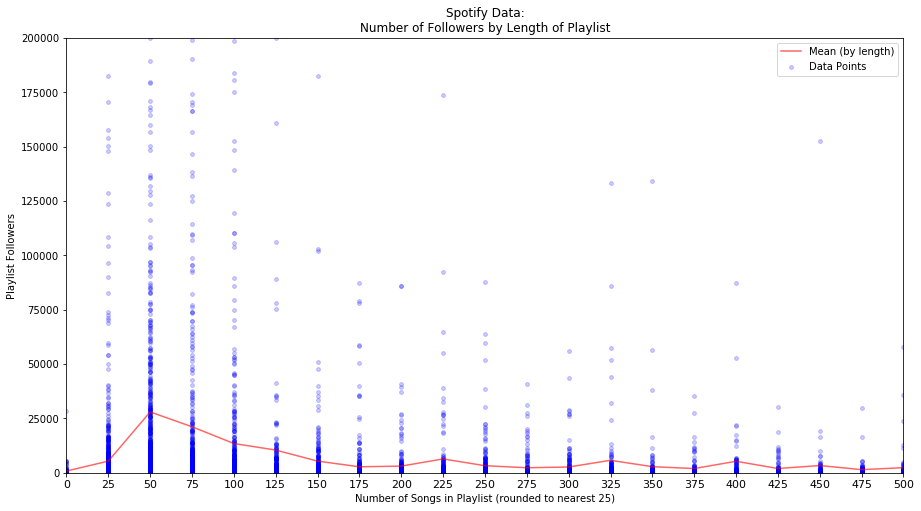

In [77]:
# Plot a scatter plot of followers vs playlist length
playlist_data['length'] = playlist_data['pl_length'].apply(lambda x: round(x / 25))
length = playlist_data['length'].values
followers = playlist_data['followers'].values
length_mean = playlist_data.groupby('length', as_index=False)['followers'].mean()

fig, ax = plt.subplots(1, figsize=(15, 8))

ax.scatter(length, followers, color='blue', alpha=0.2, label='Data Points', s=15)
ax.plot(length_mean['length'], length_mean['followers'], color='red', label='Mean (by length)', alpha=0.6)

#ax.set_xticks(np.arange(0, 1, 20))
#ax.set_yticks(np.arange(0, 200, 25))
ax.set_xticks(np.arange(0, 21))
ax.set_xticklabels(np.arange(0, 510, 25),fontsize=11)
ax.set_xlim([0,20])
ax.set_ylim([0,200000])
ax.set_xlabel('Number of Songs in Playlist (rounded to nearest 25)')
ax.set_ylabel('Playlist Followers')
ax.set_title('Spotify Data:\nNumber of Followers by Length of Playlist')
ax.legend(loc='best')
del playlist_data['length']

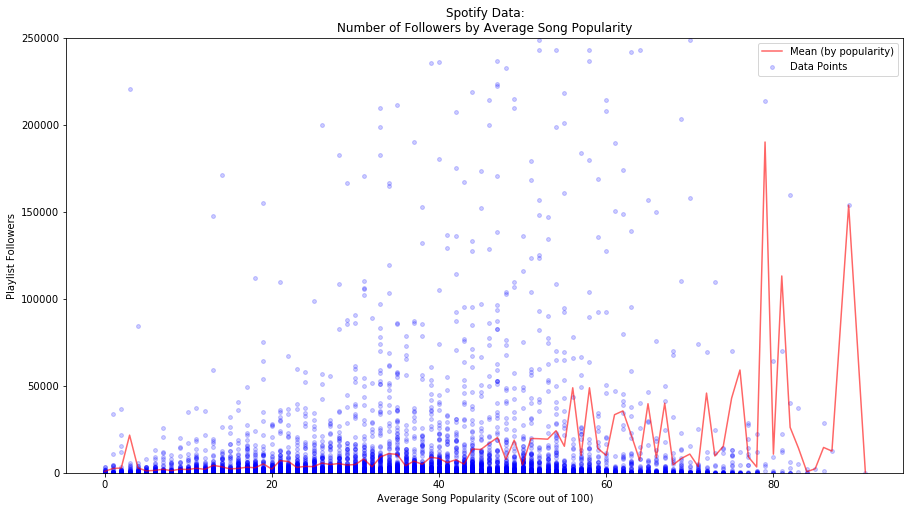

In [84]:
# Plot a scatter plot of followers vs average track popularity 
playlist_data['popularity'] = playlist_data['track_populatrity_avg'].apply(lambda x: round(x))
popularity = playlist_data['popularity'].values
followers = playlist_data['followers'].values
pop_mean = playlist_data.groupby('popularity', as_index=False)['followers'].mean()

fig, ax = plt.subplots(1, figsize=(15, 8))

ax.scatter(popularity, followers, color='blue', alpha=0.2, label='Data Points', s=15)
ax.plot(pop_mean['popularity'], pop_mean['followers'], color='red', label='Mean (by popularity)', alpha=0.6)

#ax.set_xticks(np.arange(0, 1, 20))
#ax.set_yticks(np.arange(0, 200, 25))
# ax.set_xticks(np.arange(0, 21))
# ax.set_xticklabels(np.arange(0, 510, 25),fontsize=11)
# ax.set_xlim([0,100])
ax.set_ylim([0,250000])
ax.set_xlabel('Average Song Popularity (Score out of 100)')
ax.set_ylabel('Playlist Followers')
ax.set_title('Spotify Data:\nNumber of Followers by Average Song Popularity')
ax.legend(loc='best')
del playlist_data['popularity']